# Kaggle Project 

In [1]:
import numpy as np
import pandas as pd

## Métrique de performance

In [18]:
#Indice de gini normalisé comme métrique pour mesurer la précision
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

def gini(y, y_pred_prob):
    fpr, tpr, thr = roc_curve(y, y_pred_prob, pos_label=1)
    g = 2 * auc(fpr, tpr) - 1
    return g

    
def normalized_gini(y, y_pred_prob):
    return gini(y, y_pred_prob) / gini(y, y)


norm_gini = make_scorer(normalized_gini)

In [23]:
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def normalized_gini(y, pred):
    return gini(y, pred) / gini(y, y)

# custom normalized gini score for xgb model
def gini_xgb(y, pred):
    y = y.get_label()
    return 'gini', normalized_gini(y, pred)

norm_gini = make_scorer(normalized_gini)

## Reading Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Analysis

In [3]:
X = train.drop('target',axis = 1)
y = train['target']

In [16]:
y.value_counts()

0    573518
1     21694
Name: target, dtype: int64

On a beaucoup plus de valeurs 0 que de 1, donc on s'attend à ce que les prédictions de proba pour la classe 1 soient faibles
et on va privilégier donc l'utilisation de la métrique roc_auc_score vu que le nombre de 0 et de 1 n'est pas équilibré.

In [5]:
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [5]:
#Toutes les valeurs possibles de chaque variable
for i in range(0,train.shape[1]):
    print(train.columns[i])
    print(np.unique(train.iloc[:,i]))

id
[      7       9      13 ..., 1488017 1488021 1488027]
target
[0 1]
ps_ind_01
[0 1 2 3 4 5 6 7]
ps_ind_02_cat
[-1  1  2  3  4]
ps_ind_03
[ 0  1  2  3  4  5  6  7  8  9 10 11]
ps_ind_04_cat
[-1  0  1]
ps_ind_05_cat
[-1  0  1  2  3  4  5  6]
ps_ind_06_bin
[0 1]
ps_ind_07_bin
[0 1]
ps_ind_08_bin
[0 1]
ps_ind_09_bin
[0 1]
ps_ind_10_bin
[0 1]
ps_ind_11_bin
[0 1]
ps_ind_12_bin
[0 1]
ps_ind_13_bin
[0 1]
ps_ind_14
[0 1 2 3 4]
ps_ind_15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
ps_ind_16_bin
[0 1]
ps_ind_17_bin
[0 1]
ps_ind_18_bin
[0 1]
ps_reg_01
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]
ps_reg_02
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8]
ps_reg_03
[-1.          0.06123724  0.075      ...,  3.49079146  3.78772689
  4.03794502]
ps_car_01_cat
[-1  0  1  2  3  4  5  6  7  8  9 10 11]
ps_car_02_cat
[-1  0  1]
ps_car_03_cat
[-1  0  1]
ps_car_04_cat
[0 1 2 3 4 5 6 7 8 9]
ps_car_05_cat
[-1  0  1]
ps_car_06_cat
[ 0  1  2  3  4  5  6

[ 0.          1.          1.41421356  1.73205081  2.          2.23606798
  2.44948974  2.64575131  2.82842712  3.          3.16227766  3.31662479
  3.46410162  3.60555128  3.74165739]
ps_calc_01
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]
ps_calc_02
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]
ps_calc_03
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]
ps_calc_04
[0 1 2 3 4 5]
ps_calc_05
[0 1 2 3 4 5 6]
ps_calc_06
[ 0  1  2  3  4  5  6  7  8  9 10]
ps_calc_07
[0 1 2 3 4 5 6 7 8 9]
ps_calc_08
[ 2  3  4  5  6  7  8  9 10 11 12]
ps_calc_09
[0 1 2 3 4 5 6 7]
ps_calc_10
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ps_calc_11
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
ps_calc_12
[ 0  1  2  3  4  5  6  7  8  9 10]
ps_calc_13
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
ps_calc_14
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
ps_calc_15_bin
[0 1]
ps_calc_16_bin
[0 1]
ps_calc_17_bin
[0 1]
ps_calc

## Gestion des variables catégorielles

In [4]:
#train.filter = matrice contenant les variables catégorielles 
categorical_features = train.filter(like='cat', axis=1).columns.values.tolist()
#categorical_features.remove('ps_car_11_cat') # cette variable catégorie possède beaucoup de catégories, il faut la traiter à part

In [5]:
#Les variables catégorielles sont déjà des integers il nous reste plus qu'à utiliser la technique du one-hot encoding
#columns = colonnes sélectionnées pour faire la transformation
porto_train = pd.get_dummies(train, columns=categorical_features)
porto_test = pd.get_dummies(test, columns=categorical_features)

In [8]:
#Nombre de variables après transformation avec get_dummies: 126 pour train et 125 pour test sans le target
print(porto_train.shape[1])
print(porto_test.shape[1])

229
228


In [6]:
#On supprime toutes les colonnes contenant -1 dans le nom car elles ne sont pas pertinentes
cols = [c for c in porto_train.columns if c[-2:] == '-1']

In [7]:
#Nous avons enfin réussi à nous débarrasser des valeurs manquantes de la bonne manière
porto_train = porto_train.drop(cols,1)
porto_test = porto_test.drop(cols,1)

In [11]:
#Il nous reste 117 et 116 variables pour train et test respectivement
print(porto_train.shape[1])
print(porto_test.shape[1])

220
219


## Gestion des valeurs manquantes

In [12]:
#Il reste à manipuler les valeurs manquantes des variables binaires (bin) et des variables continues
#Regardons d'abord le nombre de valeurs manquantes par variable
(np.sum(porto_train == -1)/595212*100).sort_values(ascending=False)

ps_reg_03            18.106490
ps_car_14             7.160474
ps_car_11             0.000840
ps_car_12             0.000168
ps_car_11_cat_104     0.000000
ps_car_04_cat_8       0.000000
ps_car_04_cat_6       0.000000
ps_car_04_cat_5       0.000000
ps_car_04_cat_4       0.000000
ps_car_04_cat_3       0.000000
ps_car_04_cat_2       0.000000
ps_car_04_cat_1       0.000000
ps_car_04_cat_0       0.000000
ps_car_03_cat_1       0.000000
ps_car_03_cat_0       0.000000
ps_car_02_cat_1       0.000000
ps_car_02_cat_0       0.000000
ps_car_01_cat_11      0.000000
ps_car_01_cat_10      0.000000
ps_car_01_cat_9       0.000000
ps_car_01_cat_8       0.000000
ps_car_01_cat_7       0.000000
ps_car_01_cat_6       0.000000
ps_car_01_cat_5       0.000000
ps_car_01_cat_4       0.000000
ps_car_01_cat_3       0.000000
ps_car_01_cat_2       0.000000
ps_car_01_cat_1       0.000000
ps_car_01_cat_0       0.000000
ps_car_04_cat_7       0.000000
                       ...    
ps_car_10_cat_0       0.000000
ps_car_0

In [13]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values=-1, strategy='mean', axis=0, verbose=0)

porto_train2 = imp.fit_transform(porto_train)
porto_test2 = imp.fit_transform(porto_test)

In [14]:
#Convert ndarray to pandas dataframe
porto_train2 = pd.DataFrame(porto_train2)
porto_test2 = pd.DataFrame(porto_test2)

In [15]:
porto_train2.columns = porto_train.columns
porto_test2.columns = porto_test.columns

In [16]:
X = porto_train2.drop('target', axis=1).values
y = porto_train2['target'].values
test = porto_test2.values

## Features selection : http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [8]:
X = porto_train.drop('target',axis = 1)
y = porto_train['target']

### a) Method 1: F-score

In [66]:
from xgboost import XGBClassifier
from matplotlib import pyplot

xgb = XGBClassifier()
xgb.fit(X, y)
# feature importance
importances = xgb.feature_importances_ #calcule les F-score (feature scores)
indices = np.argsort(importances)[::-1]
colonnesX = X.columns

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))
    print("%d.%s(%f)" % (f,colonnesX[indices[f]],importances[indices[f]]))

Feature ranking:
0.ps_car_13(0.120172)
1.ps_ind_03(0.100143)
2.ps_reg_03(0.087268)
3.ps_ind_05_cat_0(0.072961)
4.ps_ind_17_bin(0.067239)
5.ps_ind_15(0.052933)
6.ps_reg_01(0.045780)
7.ps_ind_01(0.040057)
8.ps_reg_02(0.034335)
9.ps_car_07_cat_1(0.031474)
10.ps_car_14(0.022890)
11.ps_car_09_cat_1(0.018598)
12.ps_ind_09_bin(0.018598)
13.ps_ind_16_bin(0.018598)
14.ps_car_01_cat_7(0.017167)
15.ps_car_15(0.015737)
16.ps_ind_06_bin(0.015737)
17.ps_ind_07_bin(0.014306)
18.ps_car_03_cat_1(0.011445)
19.ps_ind_05_cat_2(0.011445)
20.id(0.011445)
21.ps_car_11(0.010014)
22.ps_car_12(0.010014)
23.ps_ind_05_cat_6(0.010014)
24.ps_car_01_cat_6(0.008584)
25.ps_car_09_cat_0(0.008584)
26.ps_car_04_cat_0(0.008584)
27.ps_car_04_cat_2(0.008584)
28.ps_ind_04_cat_0(0.007153)
29.ps_car_06_cat_9(0.007153)
30.ps_car_11_cat(0.007153)
31.ps_car_01_cat_9(0.007153)
32.ps_ind_02_cat_1(0.007153)
33.ps_car_07_cat_0(0.005722)
34.ps_ind_02_cat_2(0.005722)
35.ps_calc_02(0.005722)
36.ps_car_06_cat_15(0.004292)
37.ps_ind_04_ca

In statistical analysis of binary classification, the F1 score (also F-score or F-measure) is a measure of a test's accuracy. It considers both the precision p and the recall r of the test to compute the score: p is the number of correct positive results divided by the number of all positive results returned by the classifier, and r is the number of correct positive results divided by the number of all true positives. The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

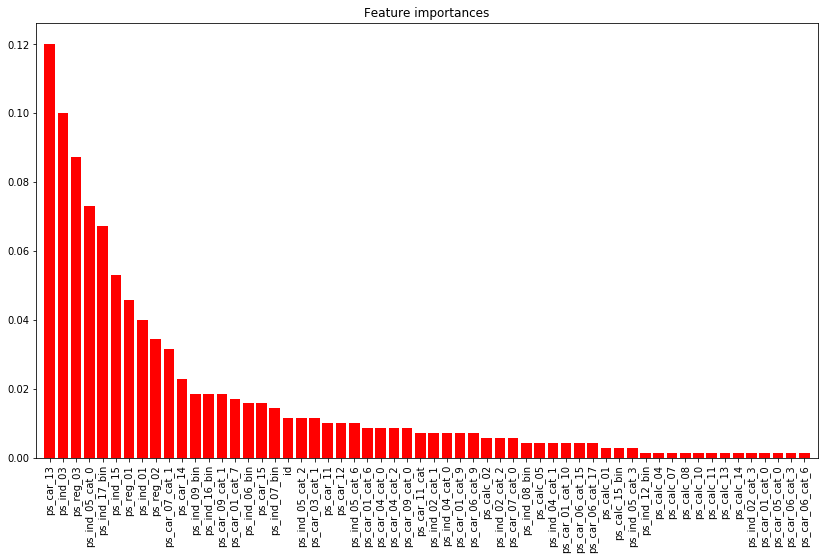

In [67]:
# plot feature importances for xgboost
from xgboost import XGBClassifier
from matplotlib import pyplot
xgb = XGBClassifier()
xgb.fit(X, y)
def feat_imp(df, model, n_features):

    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]

    pyplot.figure(figsize=(14,8))
    pyplot.title("Feature importances")
    pyplot.bar(range(n_features), [d[i] for i in top_names], color="r", align="center")
    pyplot.xlim(-1, n_features)
    pyplot.xticks(range(n_features), top_names, rotation='vertical')
    pyplot.show()

feat_imp(X, xgb, 58)


### b) Method 2: SelectKBest

The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation. For classification: chi2, f_classif, mutual_info_classif

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [69]:
import sklearn.feature_selection

def KBest(k):
    select = sklearn.feature_selection.SelectKBest(k=k)
    selected_features = select.fit(X_train,y_train)
    indices_selected = selected_features.get_support(indices = True)
    colnames_selected = [X.columns[i] for i in indices_selected]
    return colnames_selected

In [21]:
#from sklearn.metrics import roc_auc_score

def find_model_perf(X_train,y_train,X_test,y_test, model):
    model.fit(X_train,y_train)
    y_pred_prob = model.predict_proba(X_test)[:,1]
#    auc = roc_auc_score(y_test,y_pred_prob)
#    return auc

    gini = normalized_gini(y_test,y_pred_prob)
    return gini


In [102]:
from xgboost import XGBClassifier

model = XGBClassifier()
auc = []
i = 50
for k in range(50,X_train.shape[1]):
    X_train_selected = X_train[KBest(k)]
    X_test_selected = X_test[KBest(k)]
    auc.append(find_model_perf(X_train_selected, y_train, X_test_selected, y_test, model))
    print(i)
    i = i + 1
print(auc)

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
[0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.96355368383324747, 0.963553

In [98]:
best_features = KBest(k = 30)
print(best_features)

['ps_ind_01', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'ps_ind_05_cat_0', 'ps_ind_05_cat_2', 'ps_ind_05_cat_6', 'ps_car_01_cat_7', 'ps_car_01_cat_9', 'ps_car_01_cat_11', 'ps_car_02_cat_0', 'ps_car_02_cat_1', 'ps_car_03_cat_1', 'ps_car_04_cat_0', 'ps_car_04_cat_9', 'ps_car_06_cat_9', 'ps_car_06_cat_15', 'ps_car_07_cat_0', 'ps_car_07_cat_1', 'ps_car_08_cat_0', 'ps_car_08_cat_1', 'ps_car_09_cat_1']


### c) Analyse de la variance

In [96]:
np.var(X_train).sort_values(ascending = False)
#variance très grande pour ps_car_11_cat car bcp de valeurs comme on l'a vu précedemment
#on fixe un seuil pour la variance? on supprime les features avec une variance trop grande ou trop petite ?

id                  1.843582e+11
ps_car_11_cat       1.089764e+03
ps_ind_15           1.257971e+01
ps_calc_10          8.439194e+00
ps_calc_14          7.546598e+00
ps_ind_03           7.285226e+00
ps_calc_11          5.437532e+00
ps_ind_01           3.941089e+00
ps_calc_13          2.875740e+00
ps_calc_08          2.130212e+00
ps_calc_07          1.999525e+00
ps_calc_06          1.780735e+00
ps_calc_09          1.555248e+00
ps_calc_12          1.447914e+00
ps_calc_05          1.289045e+00
ps_calc_04          1.248740e+00
ps_car_11           6.934660e-01
ps_reg_03           6.301632e-01
ps_car_15           5.359944e-01
ps_calc_17_bin      2.470762e-01
ps_ind_04_cat_0     2.431947e-01
ps_ind_04_cat_1     2.431713e-01
ps_car_09_cat_2     2.413091e-01
ps_ind_06_bin       2.386925e-01
ps_calc_16_bin      2.335200e-01
ps_calc_19_bin      2.272489e-01
ps_car_01_cat_11    2.271467e-01
ps_ind_16_bin       2.240050e-01
ps_car_09_cat_0     2.202245e-01
ps_car_01_cat_7     2.101579e-01
          

## Comparaison des modèles 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [ ]:
#from sklearn.metrics import roc_auc_score

def find_model_perf(X_train,y_train,X_test,y_test, model):
    model.fit(X_train,y_train)
    y_pred_prob = model.predict_proba(X_test)[:,1]
#    auc = roc_auc_score(y_test,y_pred_prob)
#    return auc

#    gini = normalized_gini(y_test,y_pred_prob) #gini normalisé classique (voir tout en haut)
#    return gini

    gini2 = normalized_gini(y_pred_prob,y_test) #gini normalisé de BINH (voir tout en haut)
    return gini2

### ROC AUC SCORE

In [16]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC (trop long)

scores = []
models = [XGBClassifier(), LogisticRegression(), GaussianNB(), RandomForestClassifier(), ExtraTreesClassifier(), DecisionTreeClassifier()]
for i in models:
    scores.append(find_model_perf(X_train, y_train, X_test, y_test, i))
print(scores)

[0.6357625655762682, 0.49852723458999315, 0.53789798080063633, 0.53539510747404917, 0.53423516679108118, 0.50583652578744753]


In [17]:
from sklearn.neighbors import KNeighborsClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, KNeighborsClassifier())
print(score)

0.505214502174


Avec get_dummies pour toutes les variables catégorielles, le meilleur modèle est XGBClassifier pour la métrique roc_auc_score.
[XGBClassifier(), LogisticRegression(), GaussianNB(), RandomForestClassifier(), ExtraTreesClassifier(), DecisionTreeClassifier(), KNeighborsClassifier()]
[0.6357625655762682, 0.49852723458999315, 0.53789798080063633, 0.53539510747404917, 0.53423516679108118, 0.50583652578744753, 0.505214502174]

### GINI NORMALISE 1

In [16]:
from xgboost import XGBClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, XGBClassifier())
print(score)

0.269367659745


In [20]:
from sklearn.linear_model import LogisticRegression

score = find_model_perf(X_train, y_train, X_test, y_test, LogisticRegression())
print(score)

-0.00206741125065


In [11]:
from sklearn.naive_bayes import GaussianNB

score = find_model_perf(X_train, y_train, X_test, y_test, GaussianNB())
print(score)

0.0807680281279


In [12]:
from sklearn.ensemble import RandomForestClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, RandomForestClassifier())
print(score)

0.0661300921408


In [13]:
from sklearn.ensemble import ExtraTreesClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, ExtraTreesClassifier())
print(score)

0.0799807706866


In [14]:
from sklearn.tree import DecisionTreeClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, DecisionTreeClassifier())
print(score)

0.0121590892106


In [15]:
from sklearn.neighbors import KNeighborsClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, KNeighborsClassifier())
print(score)

0.00270552698655


Avec get_dummies pour toutes les variables catégorielles, le meilleur modèle est XGBClassifier pour la métrique gini normalisé
[XGBClassifier(), LogisticRegression(), GaussianNB(), RandomForestClassifier(), ExtraTreesClassifier(), DecisionTreeClassifier(), KNeighborsClassifier()]
[0.269367659745, -0.00206741125065, 0.0807680281279, 0.0661300921408, 0.0799807706866, 0.0121590892106, 0.00270552698655]

### GINI NORMALISE 2 (BINH)

In [13]:
from xgboost import XGBClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, XGBClassifier())
print(score)

C:\Users\richard\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.262092598802


In [14]:
from sklearn.linear_model import LogisticRegression

score = find_model_perf(X_train, y_train, X_test, y_test, LogisticRegression())
print(score)

0.00939402699866


In [11]:
from sklearn.naive_bayes import GaussianNB

score = find_model_perf(X_train, y_train, X_test, y_test, GaussianNB())
print(score)

0.0927778773961


In [12]:
from sklearn.ensemble import RandomForestClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, RandomForestClassifier())
print(score)

0.0583219139012


In [13]:
from sklearn.ensemble import ExtraTreesClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, ExtraTreesClassifier())
print(score)

0.048320981971


In [14]:
from sklearn.tree import DecisionTreeClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, DecisionTreeClassifier())
print(score)

0.00612834520023


In [15]:
from sklearn.neighbors import KNeighborsClassifier

score = find_model_perf(X_train, y_train, X_test, y_test, KNeighborsClassifier())
print(score)

-0.00756881473304


Avec get_dummies pour toutes les variables catégorielles, le meilleur modèle est XGBClassifier pour la métrique gini normalisé de BINH[XGBClassifier(), LogisticRegression(), GaussianNB(), RandomForestClassifier(), ExtraTreesClassifier(), DecisionTreeClassifier(), KNeighborsClassifier()] [0.262092598802, 0.00939402699866, 0.0927778773961
, 0.0583219139012, 0.048320981971, 0.00612834520023, -0.00756881473304]

## Recherche des paramètres optimaux

In [ ]:
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier
params_grid={
    'max_depth': [2,3,4,5,6,7,8],
#    'subsample': [0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#    'colsample_bytree': [0.5,0.6,0.7,0.8], 
#    'min_child_weight'=1
#    'gamma' : [0,0.5,1],
#    'n_estimators' : [200],
#    'learning_rate' : [0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3],
#    'subsample' : [0.5],
#    'colsample_bytree' : [0.5],
#    'learning_rate' : [0.05,0.06,0.07],
}

params_fixed = {
    'objective' : 'binary:logistic'
}

seed = 342
np.random.seed(seed)
best_grid = GridSearchCV(XGBClassifier(**params_fixed, seed = seed),
                  params_grid,
                  scoring='roc_auc',
                  cv = 5,
                  verbose=2)
best_grid.fit(X_train, y_train)
accuracy = best_grid.best_score_
print("Best gini obtained: {0}".format(accuracy))
print("Parameters: ")
for key,value in best_grid.best_params_.items():
    print("\t{}:{}".format(key,value))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=2 - 1.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=2 - 1.2min
[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=2 - 1.1min
[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=2 -  59.3s
[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=2 - 1.0min
[CV] max_depth=3 .....................................................
[CV] ............................................ max_depth=3 - 1.4min
[CV] max_depth=3 .....................................................
[CV] ............................................ max_depth=3 - 1.4min
[CV] max_depth=3 .....................................................
[CV] ............................................ max_depth=3 - 1.4min
[CV] m

In [ ]:
# Convert train & test to numpy arrays
X = porto_train.drop('target', axis=1).values
y = porto_train['target'].values
test = porto_test.values

# Create submission dataframe
submission = porto_test['id'].to_frame()
submission['target'] = 0

In [ ]:
kfold = 5
nrounds=500
params = {
    'eta': 0.07,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree':0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': True,
    'n_jobs':1 # use all CPU cores
}

kf = KFold(n_splits=kfold, shuffle=True, random_state=322)

for i, (train_index, cv_index) in enumerate(kf.split(X)):

    print(' xgb kfold: {} of {} : '.format(i+1, kfold))
    X_train, X_eval = X[train_index,:], X[cv_index,:]
    y_train, y_eval = y[train_index], y[cv_index]

    d_train = xgb.DMatrix(X_train, y_train) 
    d_valid = xgb.DMatrix(X_eval, y_eval)

    watchlist = [(d_train, 'train'), (d_valid, 'eval')]
    xgb_model = xgb.train(params,
                          d_train,
                          nrounds,
                          watchlist,
                          early_stopping_rounds=100,
                          feval=gini_xgb,
                          maximize=True,
                          verbose_eval=50)
    # Updating prediction by taking the average
    submission['target'] += xgb_model.predict(xgb.DMatrix(test)) / kfold
